# Matrix Factorization - BRP(Bayesian Personalized Ranking)
- BPR은 implicit data에 사용 가능한 matrix factorization 알고리즘 중 하나입니다.

In [1]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sb
from scipy.sparse import csr_matrix
import sys
from implicit.bpr import BayesianPersonalizedRanking as BPR
import pickle as pk
from sklearn.decomposition import PCA
from annoy import AnnoyIndex

np.set_printoptions(3)

In [2]:
plays_df = pd.read_csv("plays.csv")
arts_df = pd.read_csv("artists.csv")
users_df = pd.read_csv("users.csv")

### Implicit Data 해석하기
- 재생 횟수를 별점으로 해석하면 안 됩니다.
- 그 이유는 데뷔한 지 오래되거나 발표한 곡이 많을수록 해당 아티스트의 재생 횟수는 일반적으로 많을 수밖에 없기 때문입니다.
- BPR에서는 재생 횟수를 그대로 사용하는 것이 아니라 재생 여부만을 봅니다.
- 이때 재생한 적 있는 아티스트를 재생한 적 없는 아티스트보다 선호한다는 가정을 깔고 갑니다.
- BPR은 긍정 아이템과 부정 아이템 간의 랭킹의 차이를 objective function으로 하여 그 값이 커지도록 embedding합니다.

In [3]:
plays_df

,user_id,artist_id,plays
0,0,0,2137
1,0,1,1099
2,0,2,897
3,0,3,717
4,0,4,706
...,...,...,...
17302618,359346,193,61
17302619,359346,9965,61
17302620,359346,1549,59
17302621,359346,806,58


In [4]:
# 사용자별 플레이한 적이 있는 아피스트의 집합
in_plays = plays_df.groupby(["user_id"])["artist_id"].apply(frozenset)

In [5]:
in_plays

user_id
0         (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
1         (49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 6...
2         (128, 129, 130, 131, 132, 133, 134, 135, 136, ...
3         (146, 147, 148, 149, 150, 151, 152, 153, 154, ...
4         (12, 51, 194, 195, 196, 197, 198, 199, 200, 20...
                                ...                        
359342    (5, 1415, 264, 6923, 1679, 527, 5519, 2070, 20...
359343    (515, 260, 7943, 17675, 783, 276, 2580, 790, 2...
359344    (8704, 3713, 8066, 1155, 2432, 3717, 8070, 233...
359345    (3328, 5, 2062, 281, 132638, 928, 426, 1199, 1...
359346    (12675, 10244, 4484, 266, 8074, 1549, 10127, 1...
Name: artist_id, Length: 358856, dtype: object

In [41]:
all_arts = set(plays_df["artist_id"])

In [42]:
top_users = plays_df["user_id"].value_counts()[:100].index
top_arts = plays_df["artist_id"].value_counts()[:100].index

top100 = plays_df[(plays_df["user_id"].isin(top_users)) & (plays_df["artist_id"].isin(top_arts))]

In [43]:
top100

,user_id,artist_id,plays
260488,5401,485,1677
260489,5401,216,1287
260493,5401,789,517
260496,5401,2724,356
260500,5401,245,265
...,...,...,...
16852093,349949,995,121
16852100,349949,707,79
16852112,349949,245,51
16852129,349949,992,39


## numpy로 BPR 구현하기

In [44]:
users_df.sample(5)

,user_id,gender,age,country
155667,155667,m,15,Brazil
206423,206423,m,21,Russian Federation
2515,2515,m,20,New Zealand
271267,271267,m,16,Russian Federation
162146,162146,m,28,Italy


In [45]:
arts_df

,artist_id,artist_name
0,0,betty blowtorch
1,1,die Ärzte
2,2,melissa etheridge
3,3,elvenking
4,4,juliette & the licks
...,...,...
160105,160105,ronny elliott
160106,160106,magenta broken
160107,160107,bound for attack
160108,160108,sacred buddha


In [46]:
n_facts = 10 # 임베딩 변수의 갯수

user_embs = np.random.normal(size=(len(users_df), n_facts))
art_embs = np.random.normal(size=(len(arts_df), n_facts))
bias_embs = np.random.normal(size=(len(arts_df), ))

def sig(x):
    return 1 / (1 + np.exp(-x))

lr = 2
reg = 0.01 # 정규화
n_epochs = 10 # 총 학습 수

hist = []
for epoch in tqdm(range(1, n_epochs+1)):
    history = []
    for c, (idx, row) in enumerate(top100.iterrows()):
        # 각 행에 대한 n회차의 학습
        
        user = row["user_id"]
        user_emb = user_embs[user]
        
        # 사용자가 들어본 적 있는 아티스트에 대해서 해당 아티스트의 임베딩 벡터 가져오기
        pos_art = row["artist_id"]
        pos_art_emb = art_embs[pos_art]
        pos_bias = bias_embs[pos_art]
        
        #사용자가 들어본 적 없는 아티스트 중 랜덤으로 1개 샘플링, 해당 아티스트의 임베딩 벡터 가져오기
        notin_plays = all_arts - in_plays[user]
        neg_art = random.choice(list(notin_plays))
        neg_art_emb = art_embs[neg_art]
        neg_bias = bias_embs[neg_art]
        
        pos_score = np.dot(user_emb, pos_art_emb) + pos_bias
        neg_score = np.dot(user_emb, neg_art_emb) + neg_bias
        
        diff = pos_score - neg_score
        loss = sig(diff)
        
        user_embs[user] -= lr*(loss*(loss-1)*(pos_art_emb-neg_art_emb) - reg*user_emb)
        art_embs[pos_art] -= lr*(loss*(loss-1)*user_emb - reg*pos_art_emb)
        art_embs[neg_art] -= lr*(-loss*(loss-1)*user_emb - reg*neg_art_emb)
        
        bias_embs[pos_art] -= lr*(loss*(loss-1) - reg*pos_bias)
        bias_embs[neg_art] -= lr*(-loss*(loss-1) - reg*neg_bias)
        
        correct = (loss>=0.5)
        hist.append(correct)
    acc = sum(hist)/len(hist)
    print(f"epoch : {epoch} | acc : {acc:2.3%}")

 10%|████████▎                                                                          | 1/10 [00:11<01:43, 11.47s/it]

epoch : 1 | acc : 56.068%


 20%|████████████████▌                                                                  | 2/10 [00:22<01:31, 11.46s/it]

epoch : 2 | acc : 65.049%


 20%|████████████████▌                                                                  | 2/10 [00:32<02:09, 16.24s/it]


KeyboardInterrupt: 

- user_emb = [u1, u2, ...]
- pos_art_emb = [p1, p2, ...]
- neg_art_emb = [n1, n2, ...]
- pos_bias = [b1, b2, ...]
- neg_bias = [b1', b2', ...]
라 하면

- diff = [u1(p1-n1)+(b1-b1'), u2(p2-n2)+(b2-b2'), ...]
- d(loss)/d(user_emb) = d(loss)/d(diff) * d(diff)/d(user_emb) = loss(1-loss) * (pos_art_emb-neg_art_emb)

### K-Core Pruning
- 모든 유저의 재생 횟수 데이터를 이용해서 추천 시스템을 만든다고 좋은 것은 아닙니다. 2명에서 3명의 아티스트만 고집해서 듣는 유저와, 2명에서 3명의 유저만이 듣는 아티스트의 재생 정보는 Matrix Factorization을 통해 올바르게 임베딩을 하기 어렵습니다. 이렇게 적은 정보를 가진 유저와 아티스트들은 특정 값으로 편향될 우려가 있기 때문에, 모델의 학습이 일반화되지 못할 우려가 있습니다. 따라서 적절한 기준을 가지고 편향을 발생시킬 우려가 있는 샘플은 제거해야 합니다.
- 이때 사용할 수 있는 샘플링 방법 중 하나가 K-core Pruning 기법입니다. K-core Pruning은 K개 이상의 데이터가 보장된 샘플들만 추출하는 샘플링 기법입니다.
- Last.fm 데이터에 적용한다면, K명 이상의 유저가 들은 아티스트만 남기고, K명 이상의 아티스트의 음악을 들은 유저만 남기는 것이죠.


In [47]:
plays_df

,user_id,artist_id,plays
0,0,0,2137
1,0,1,1099
2,0,2,897
3,0,3,717
4,0,4,706
...,...,...,...
17302618,359346,193,61
17302619,359346,9965,61
17302620,359346,1549,59
17302621,359346,806,58


In [48]:
#어떤 사용자가 어떤 아티스트의 음악을 재생한 횟수가 특정 값 이상인 경우에만 그 아티스트의 음악을 좋아한다고 가정합니다.
#여기서는 그 특정 값을 사용자 및 아티스트별 재생 횟수의 전체 하위 10퍼센트로 합니다. 
likes_df = plays_df[plays_df["plays"]>plays_df["plays"].quantile(0.1)]

thrsd = 5
cnt = 0
while True:
    cnt += 1
    len_before = len(likes_df)
    print(f"len(likes_df) : {len(likes_df):,}")
    #thrsd 이상의 아티스트의 음악을 들은 사용자들의 리스트
    n_arts_per_user = likes_df["user_id"].value_counts()
    exec(f"users_over{thrsd}arts = n_arts_per_user[n_arts_per_user>thrsd].index")

    #thrsd 이상의 사용자를 확보한 아티스트들의 리스트
    n_users_per_art = likes_df["artist_id"].value_counts()
    exec(f"arts_over{thrsd}users = n_users_per_art[n_users_per_art>thrsd].index")

    likes_df = likes_df[(likes_df["user_id"].isin(eval(f"users_over{thrsd}arts")) & likes_df["artist_id"].isin(eval(f"arts_over{thrsd}users")))]
    len_after = len(likes_df)
    #더 이상 갯수의 변화가 없으면 종료합니다.
    if len_after == len_before:
        break
print("finished!")

len(likes_df) : 15,494,436
len(likes_df) : 15,306,742
len(likes_df) : 15,305,394
len(likes_df) : 15,305,294
finished!


In [49]:
all_users = list(set(plays_df["user_id"]))
users_likes_df = list(set(likes_df["user_id"]))

print(f"사용자 수의 변화 : {len(all_users):,} -> {len(users_likes_df):,}({len(users_likes_df)/len(all_users):.1%})")

all_arts = list(set(plays_df["artist_id"]))
arts_likes_df = list(set(likes_df["artist_id"]))

print(f"아티스트 수의 변화 : {len(all_arts):,} -> {len(arts_likes_df):,}({len(arts_likes_df)/len(all_arts):.1%})")

사용자 수의 변화 : 358,856 -> 342,852(95.5%)
아티스트 수의 변화 : 160,110 -> 73,556(45.9%)


- likes_df에 포함되지 않은 사용자와 아티스트는 추천 시스템을 만들기 위한 Matrix Factorization 대상에서 제외됩니다.
- 이처럼 초기 정보가 부족해서 추천 시스템을 제공하지 못하는 사용자와 아티스트가 발생하는 문제를 Cold Start라 합니다.
- 이러한 사용자 또는 아티스트에게는 다른 추천 시스템을 제공해야 합니다.

### Convert User-Item Matrix of Dense Matrix to Sparse Matrix
- sparse representation으로 표현된 dense matrix를 그대로 ndarray로 변환하면 메모리의 낭비가 극심하므로 sparse matrix로 변환하는 것이 필요합니다.
- scipy.sparse의 csr_matrix는 데이터와 인덱스를 따로 저장함으로써 그것을 실현하는 방법입니다.

In [50]:
#example
vals = [2, 4, 3, 4, 1, 1, 2]
rows = [0, 1, 2, 2, 3, 4, 4]
cols = [0, 2, 5, 6, 14, 0, 1]

sparse_mat = csr_matrix((vals,  (rows,  cols)))

In [51]:
sparse_mat.todense()

matrix([[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 3, 4, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)

In [52]:
likes_df

,user_id,artist_id,plays
0,0,0,2137
1,0,1,1099
2,0,2,897
3,0,3,717
4,0,4,706
...,...,...,...
17302618,359346,193,61
17302619,359346,9965,61
17302620,359346,1549,59
17302621,359346,806,58


In [53]:
#user_id와 artist_id의 dtype을 category로 변환합니다.
likes_df["user_id"] = pd.Categorical(likes_df["user_id"])
likes_df["artist_id"] = pd.Categorical(likes_df["artist_id"])

#변환된 각 값의 0부터 새롭게 부여된 index를 rows, cols로 정의합니다.
vals = likes_df["plays"]
rows = likes_df["artist_id"].cat.codes.values
cols = likes_df["user_id"].cat.codes.values

inputs = csr_matrix((vals, (rows, cols)))

In [54]:
print(f"inputs.todense() : {inputs.shape[0]*inputs.shape[1]*8/2**30:,.2f}GB")
print(f"inputs : {inputs.data.nbytes/2**30:,.2f}GB")

inputs.todense() : 187.89GB
inputs : 0.11GB


## implicit libarary BRP 구현하기

- implicit은 파이썬으로 implicit data를 이용한 협업 필터링 추천 시스템을 만들 때 사용하는 패키지로, 앞서 의사코드로 작성한 코드보다 최적화가 되어있기 때문에 빠릅니다.
- 설치
````shell
pip install implicit
conda install -c conda-forge implicit
````

In [57]:
#model을 .pk로 저장한 파일이 있으면 불러오고 없으면 저장합니다.
file = "implicit_bpr_model.pk"
if os.path.exists(file):
    with open(file, "rb") as f:
        model = pk.load(f)
else:
    with open(file, "wb") as f:
        model = BPR(factors=60)
        
        model.fit(inputs)
        
        pk.dump(model, f)

In [58]:
user_embs = model.user_factors
art_embs = model.item_factors

In [59]:
#embedding vector에는 마지막에 bias가 하나씩 붙어서 크기가 factors+1이 됩니다.
art_embs.shape

(73556, 61)

In [60]:
art_embs

array([[ 0.109,  0.252,  0.289, ..., -0.027, -0.131, -0.165],
       [ 0.23 , -0.086,  0.038, ...,  0.386, -0.514,  0.009],
       [-0.407,  0.111,  0.226, ..., -0.561, -0.285, -0.069],
       ...,
       [-0.119,  0.02 , -0.179, ..., -0.111,  0.103,  0.299],
       [-0.079,  0.099, -0.081, ...,  0.073,  0.204,  0.294],
       [-0.073,  0.054, -0.045, ..., -0.156, -0.05 ,  0.413]],
      dtype=float32)

좀 더 가독성을 높이기 위해서 각 임베딩 행 별로 아티스트의 이름과 유저의 id를 매칭시켜 데이터프레임(dataframe)을 구성하도록 하겠습니다.

In [61]:
art_id2name = {key:value for key, value in zip(arts_df["artist_id"], arts_df["artist_name"])}
idxes = [art_id2name[art_id] for art_id in likes_df["artist_id"].cat.categories]

art_embs_df = pd.DataFrame(art_embs, index=idxes)

In [62]:
art_embs_df.sample(5)

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
huevos rancheros,-0.128699,0.311649,-0.374715,-0.355780,-0.063657,-0.185944,-0.444533,0.127571,-0.222756,0.366999,...,-0.396194,-0.208720,0.115938,-0.096317,0.536716,-0.277599,0.151901,-0.319879,0.438018,0.297204
drop alive,-0.093337,0.066834,0.009173,-0.031366,0.184667,-0.042522,-0.300300,0.006049,-0.204772,0.033760,...,-0.030654,0.182847,0.026871,-0.042572,-0.066415,0.003014,-0.082323,-0.061317,0.151675,0.570283
lobo,-0.379092,-0.125619,-0.367632,-0.263959,0.063918,-0.146741,-0.314746,-0.025037,0.277174,-0.096047,...,0.284975,0.053466,0.319176,0.151117,-0.236929,0.049413,0.194379,-0.404312,-0.021392,-0.150015
füsun Önal,-0.066290,-0.231581,0.184301,0.126819,0.202142,-0.142408,-0.176541,0.273579,0.331233,-0.221754,...,-0.063479,0.266539,0.130209,-0.209151,-0.404720,0.030549,-0.081505,-0.487093,0.007383,0.192278
steve allen,-0.142022,0.073846,-0.221967,-0.313085,0.251768,-0.279772,-0.283878,0.179852,0.375138,-0.012432,...,-0.025183,-0.086294,0.316019,-0.001279,-0.159714,0.014732,-0.244191,-0.106353,0.146192,0.506568


In [63]:
user_embs_df = pd.DataFrame(user_embs, index=likes_df["user_id"].cat.categories)

In [64]:
user_embs_df.sample(5)

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
293753,0.183880,-0.123787,0.131343,-0.242225,0.857163,-0.406753,-0.072917,-0.331580,0.196037,-0.186362,...,0.255680,0.308144,0.094511,0.461413,-0.176588,0.199080,-0.161310,0.559454,-0.444640,1.0
227839,-0.355870,-0.321303,-0.089576,-0.264149,0.232885,0.149644,-0.111460,-0.072513,0.417461,-0.540774,...,0.399392,0.330673,-0.477788,0.146596,-0.177143,0.467442,0.050947,-0.082464,-0.611169,1.0
19190,0.034988,0.022122,-0.474046,-0.257562,0.260446,-0.172892,-0.065179,0.399391,0.224344,-0.094946,...,-0.137385,-0.093471,0.240009,-0.252805,-0.124705,0.197823,-0.305211,0.128390,0.233130,1.0
11821,0.175607,-0.025159,0.022882,-0.047607,-0.300889,0.556049,0.182738,-0.138923,0.203091,-0.097054,...,0.416218,-0.200041,-0.418654,0.382311,-0.099579,0.201069,-0.043523,0.202142,-0.166547,1.0
149175,-0.183554,0.257524,0.112144,0.201169,-0.622288,-0.039700,0.268850,-0.179444,0.267655,-0.159785,...,0.327291,-0.138160,0.151876,0.572370,0.054791,-0.509320,0.318751,-0.462765,0.130175,1.0


- user_embs_df와 art_embs_df를 이용해 3가지 추천 알고리즘을 구현할 수 있습니다.
    1. 좋아하는 아티스트와 유사한 아티스트 추천
    2. 사용자와 유사한 취향을 가진 사용자가 좋아하는 아티스트 추천
    3. 사용자의 취향과 유사한 특성을 가진 아티스트 추천

### 1. 좋아하는 아티스트와 유사한 아티스트 추천

In [65]:
def cos_sim(x, y):
    return x.dot(y)/(np.linalg.norm(x, axis=1, ord=2)*np.linalg.norm(y, ord=2))

In [66]:
#리한나와 유사한 아티스트 10명
target = art_embs_df.loc["rihanna"].values

cos_sim(art_embs_df, target).sort_values(ascending=False)[:10]

rihanna               1.000000
fergie                0.959289
the pussycat dolls    0.958751
beyoncé               0.939941
rhianna               0.930461
britney spears        0.919116
kat deluna            0.917435
ashley roberts        0.914866
jessie malakouti      0.912610
lady gaga             0.907357
dtype: float32

In [67]:
#제이슨 므라즈와 유사한 아티스트 10명
target = art_embs_df.loc["jason mraz"].values

cos_sim(art_embs_df, target).sort_values(ascending=False)[:10]

jason mraz                      1.000000
gavin degraw                    0.901576
joshua radin & schuyler fisk    0.883766
matt white band                 0.882751
justin nozuka                   0.873454
colbie caillat                  0.865914
matt white                      0.865277
teddy geiger                    0.863368
matt white                      0.858855
john mayer                      0.854577
dtype: float32

In [68]:
#에미넴과 유사한 아티스트 10명
target = art_embs_df.loc["eminem"].values

cos_sim(art_embs_df, target).sort_values(ascending=False)[:10]

eminem             1.000000
d12                0.912591
50 cent            0.881810
dmx                0.860071
2pac               0.853796
ying yang twins    0.827247
obie trice         0.818008
xzibit             0.812668
coolio             0.808042
sans pression      0.805561
dtype: float32

### 2. 사용자와 유사한 취향을 가진 사용자가 좋아하는 아티스트 추천
- 유저 취향 임베딩 행렬과 유저의 정보 데이터(연령, 성별 등)를 같이 활용하면, 유저의 특성별(연령대별, 세대별, 성별 등) 음악적 취향이 어떻게 차이가 나는지를 시각화하여 분석할 수 있습니다.
- 유저 임베딩 데이터를 이용해 유저군을 분석해봅시다. 임베딩 행렬을 시각화하기 위해서 임베딩 행렬의 차원을 2차원으로 줄이는 작업이 필요합니다. 데이터가 2차원을 넘어가면 시각화가 쉽지 않기 때문입니다. 데이터의 차원을 줄이기 위한 방법 중 하나가 바로 주성분 분석(PCA, Principal Component Analysis)입니다. 주성분 분석은 원본 데이터의 가장 정보를 덜 손상시키는 방향으로 주성분 N개를 추출하여 N개의 차원으로 데이터를 줄여줍니다. PCA는 파이썬의 대표적인 머신러닝 패키지 중 하나인 scikit-learn에서 제공됩니다.

In [69]:
pca = PCA(n_components=2)
pca_mat = pca.fit_transform(user_embs_df)
pca_mat_df = pd.DataFrame(pca_mat, index=user_embs_df.index, columns=["comp1", "comp2"])

In [70]:
pca_mat_df

,comp1,comp2
0,0.831985,0.107288
1,-0.926918,0.078855
2,-1.101584,1.585894
3,1.284887,0.851557
4,-1.876118,0.797699
...,...,...
359342,0.048937,-0.823796
359343,-1.219771,-0.294600
359344,0.494300,1.429064
359345,1.168618,0.756548


#### 성별에 따른 취향
- 사용자들의 성별에 따른 취향의 차이를 시각화 해보겠습니다.

In [71]:
users_df

,user_id,gender,age,country
0,0,f,22,Germany
1,1,f,-1,Canada
2,2,None,-1,Germany
3,3,m,19,Mexico
4,4,m,28,United States
...,...,...,...,...
359342,359342,m,25,Germany
359343,359343,m,25,Brazil
359344,359344,m,20,United States
359345,359345,m,20,Russian Federation


In [72]:
user_id2gender = {user_id:gender for user_id, gender in zip(users_df["user_id"], users_df["gender"])}
pca_mat_df["gender"] = pca_mat_df.apply(lambda x : user_id2gender[x.name], axis=1)

In [73]:
pca_mat_df

,comp1,comp2,gender
0,0.831985,0.107288,f
1,-0.926918,0.078855,f
2,-1.101584,1.585894,None
3,1.284887,0.851557,m
4,-1.876118,0.797699,m
...,...,...,...
359342,0.048937,-0.823796,m
359343,-1.219771,-0.294600,m
359344,0.494300,1.429064,m
359345,1.168618,0.756548,m


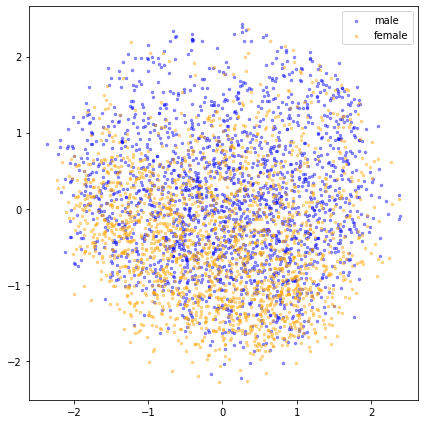

In [74]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(data=pca_mat_df[pca_mat_df["gender"]=="m"].sample(2000), x="comp1", y="comp2", s=6, alpha=0.4, c="blue", label="male")
ax.scatter(data=pca_mat_df[pca_mat_df["gender"]=="f"].sample(2000), x="comp1", y="comp2", s=6, alpha=0.4, c="orange", label="female")

ax.legend()

fig.tight_layout()

- female이 조금 더 아래로 치우쳐서 있는 것을 볼 수 있습니다.

#### 나이에 따른 취향
- 사용자들의 나이에 따른 취향의 차이를 시각화 해보겠습니다.

In [75]:
user_id2age = {user_id:age for user_id, age in zip(users_df["user_id"], users_df["age"])}
pca_mat_df["age"] = pca_mat_df.apply(lambda x : user_id2age[x.name], axis=1)

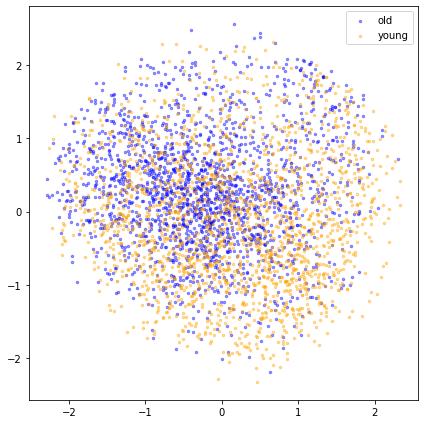

In [76]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(data=pca_mat_df[pca_mat_df["age"]>=60].sample(2000), x="comp1", y="comp2", s=6, alpha=0.4, c="blue", label="old")
ax.scatter(data=pca_mat_df[pca_mat_df["age"]<=20].sample(2000), x="comp1", y="comp2", s=6, alpha=0.4, c="orange", label="young")

ax.legend()

fig.tight_layout()

- 서로 다른 분포를 볼 수 있습니다.

- 성별 혹은 연령별로 유저를 분석하여 유저에 대한 이해도를 높이는 것은 좋은 추천시스템을 만드는데 반드시 필요한 작업입니다. 예를 들어 앞서 언급했던 Cold Start 문제를 해결하기 위해 같은 성별 혹은 연령대의 유저군에 속한 유저들이 좋아하는 아티스트를 추천할 수도 있을 것입니다. 또는 마케팅을 수행하는데 활용할 수도 있을 것입니다.

### 3. 사용자의 취향과 유사한 특성을 가진 아티스트 추천

In [77]:
#락을 좋아하는 사용자
user_id = 300

print([art_id2name[art_id] for art_id in in_plays.loc[user_id]], end="\n\n")
print(cos_sim(art_embs_df, user_embs_df.loc[user_id]).sort_values(ascending=False)[:10])

['angelo badalamenti', 'red hot chili peppers', 'marilyn manson', 'led zeppelin', 'eric clapton', 'metallica', 'iron maiden', 'u2', 't.love', 'slipknot', 'queens of the stone age', "guns n' roses", 'iced earth', 'avril lavigne', 'guano apes', 'the offspring', 'alice in chains', 'in flames', 'pantera', 'john williams', 'daniel licht', 'high and mighty color', 'karmacoma', 'down', 'missile girl scoot', 'akira yamaoka', 'the kilimanjaro darkjazz ensemble', 'mondo generator', 'raging speedhorn', 'graeme revell', 'spiritual beggars', 'as i lay dying', 'frida snell', 'fatboy slim', 'pearl jam', 'isis', 'suicidal tendencies', 'black sabbath', 'stone sour', 'the smashing pumpkins', 'sigur rós', 'godsmack', 'pink', 'no doubt', 'nine inch nails']

downface                       0.841588
crew                           0.832902
vokee                          0.824441
triquetra                      0.823269
tosteer                        0.822168
guess why                      0.803374
future leade

In [78]:
#힙합을 좋아하는 사용자
user_id = 1200

print([art_id2name[art_id] for art_id in in_plays.loc[user_id]], end="\n\n")
print(cos_sim(art_embs_df, user_embs_df.loc[user_id]).sort_values(ascending=False)[:10])

['the stone roses', 'snow patrol', 'red hot chili peppers', 'nickelback', 'scouting for girls', 'blur', 'michael jackson', 'michael bublé', 'amy winehouse', 'u2', 'the fratellis', 'bob marley', 'busted', 'jay-z', 'prince', 'kanye west', 'jordin sparks', 'foo fighters', '2pac', 'arctic monkeys', '50 cent', 'coldplay', 'lil wayne', 'the jackson 5', 'shaggy', 'queen', 'the game', 'feeder', 'the streets', 'radiohead', 'jay-z and linkin park', 'rihanna', 'linkin park', 'nina simone', 'blink-182', 'basshunter', 'r. kelly', 'oasis', 'the view', 'usher', 'the verve', 'akon', 'rod stewart', 'stereophonics', 'hard-fi']

donavon frankenreiter & jack johnson    0.834244
marky mark & the funky bunch            0.828939
def rhymz                               0.816024
dj greg j                               0.803926
sek loso                                0.795295
mash up                                 0.781428
triple m                                0.781175
peter kay                              

In [79]:
#댄스 음악을 좋아하는 사용자
user_id = 209

print([art_id2name[art_id] for art_id in in_plays.loc[user_id]], end="\n\n")
print(cos_sim(art_embs_df, user_embs_df.loc[user_id]).sort_values(ascending=False)[:10])

['gackt', 'christina aguilera', 'beyoncé', 'michael jackson', '安室奈美恵', '12012', '이효리', '新垣結衣', '久石譲', '鄭秀文', 'olivia ong', 'donawhale', '王力宏', 'enrique iglesias', 'alan', 'late night alumni', 'vanessa paradis', 'big bang', 'uverworld', 'abingdon boys school', 'britney spears', 'jennifer lopez', 'timbaland', 'ciara', 'bon jovi', 'avril lavigne', '中島美嘉', '浜崎あゆみ', 'm-flo', 'evanescence', '宇多田ヒカル', 'olivia', '倖田來未', 'spice girls', 'ashlee simpson', 'mariah carey', 'rihanna', 'linkin park', 'nelly furtado', 'madonna', 'enya', 'the pussycat dolls', 'kelly clarkson', 'michelle branch', 'frank sinatra', 'bee gees', 'justin timberlake', 'lady gaga', 'mink', 'boa', 'ガゼット', 'disney']

kavana           0.918612
大野智              0.918307
guo mei mei      0.914705
park jung ah     0.913502
櫻井翔              0.910847
김조한              0.909523
tashannie        0.909446
erin hamilton    0.907806
angela vía       0.907226
alyssa milano    0.904699
dtype: float32


## 유사도 계산 속도 개선하기
- 실제로 추천 시스템을 구현할 경우 최소 100ms 안에 서비스를 제공해야 합니다.
- 그러나 pandas를 이용해 유사도를 계산하는 것은 대량의 요청에 빠른 속도로 응답하기가 어렵습니다.

### annoy library 사용하기
- 전체 사용자 또는 아이템에 대해 연산을 수행하는 것이 아니라 유사도가 높을 것으로 예상되는 사용자 또는 아이템들을 추려낸 후 해당 사용자 또는 아이템들만을 가지고 유사도를 계산하므로 훨씬 빠른 연산 속도를 구현할 수 있습니다.
- 이처럼 유사도를 빠르게 계산할 수 있도록 해주는 libraries는 다음과 같은 것들이 있습니다.
<img src="https://github.com/erikbern/ann-benchmarks/raw/master/results/glove-100-angular.png" width="500">

In [34]:
n_facts = 61
tree = AnnoyIndex(n_facts, "dot")

for idx, value in enumerate(art_embs_df.values):
    tree.add_item(idx, value)

#builds a forest of n_trees trees. More trees gives higher precision when querying.
tree.build(n_trees=20)

In [97]:
#락을 좋아하는 사용자
user_id = 300

print([art_id2name[art_id] for art_id in in_plays.loc[user_id]], end="\n\n")
print([art_id2name[art] for art in tree.get_nns_by_vector(user_embs_df.loc[user_id], 10)])

['angelo badalamenti', 'red hot chili peppers', 'marilyn manson', 'led zeppelin', 'eric clapton', 'metallica', 'iron maiden', 'u2', 't.love', 'slipknot', 'queens of the stone age', "guns n' roses", 'iced earth', 'avril lavigne', 'guano apes', 'the offspring', 'alice in chains', 'in flames', 'pantera', 'john williams', 'daniel licht', 'high and mighty color', 'karmacoma', 'down', 'missile girl scoot', 'akira yamaoka', 'the kilimanjaro darkjazz ensemble', 'mondo generator', 'raging speedhorn', 'graeme revell', 'spiritual beggars', 'as i lay dying', 'frida snell', 'fatboy slim', 'pearl jam', 'isis', 'suicidal tendencies', 'black sabbath', 'stone sour', 'the smashing pumpkins', 'sigur rós', 'godsmack', 'pink', 'no doubt', 'nine inch nails']

['bones brigade', 'sycronomica', 'alice in chains', 'system of a down', 'the distillers', 'ke$ha', 'me first and the gimme gimmes', 'otto ohm', 'guano apes', 'nephew']


In [98]:
#힙합을 좋아하는 사용자
user_id = 1200

print([art_id2name[art_id] for art_id in in_plays.loc[user_id]], end="\n\n")
print([art_id2name[art] for art in tree.get_nns_by_vector(user_embs_df.loc[user_id], 10)])

['the stone roses', 'snow patrol', 'red hot chili peppers', 'nickelback', 'scouting for girls', 'blur', 'michael jackson', 'michael bublé', 'amy winehouse', 'u2', 'the fratellis', 'bob marley', 'busted', 'jay-z', 'prince', 'kanye west', 'jordin sparks', 'foo fighters', '2pac', 'arctic monkeys', '50 cent', 'coldplay', 'lil wayne', 'the jackson 5', 'shaggy', 'queen', 'the game', 'feeder', 'the streets', 'radiohead', 'jay-z and linkin park', 'rihanna', 'linkin park', 'nina simone', 'blink-182', 'basshunter', 'r. kelly', 'oasis', 'the view', 'usher', 'the verve', 'akon', 'rod stewart', 'stereophonics', 'hard-fi']

['dr. dre', 'bloc party', 'roupa nova', 'ray eberle', 'red hot chili peppers', 'devonsquare', 'soul merchants', 'hardcore authority', 'angus stone', 'talking cure']


In [99]:
#댄스 음악을 좋아하는 사용자
user_id = 209

print([art_id2name[art_id] for art_id in in_plays.loc[user_id]], end="\n\n")
print([art_id2name[art] for art in tree.get_nns_by_vector(user_embs_df.loc[user_id], 10)])

['gackt', 'christina aguilera', 'beyoncé', 'michael jackson', '安室奈美恵', '12012', '이효리', '新垣結衣', '久石譲', '鄭秀文', 'olivia ong', 'donawhale', '王力宏', 'enrique iglesias', 'alan', 'late night alumni', 'vanessa paradis', 'big bang', 'uverworld', 'abingdon boys school', 'britney spears', 'jennifer lopez', 'timbaland', 'ciara', 'bon jovi', 'avril lavigne', '中島美嘉', '浜崎あゆみ', 'm-flo', 'evanescence', '宇多田ヒカル', 'olivia', '倖田來未', 'spice girls', 'ashlee simpson', 'mariah carey', 'rihanna', 'linkin park', 'nelly furtado', 'madonna', 'enya', 'the pussycat dolls', 'kelly clarkson', 'michelle branch', 'frank sinatra', 'bee gees', 'justin timberlake', 'lady gaga', 'mink', 'boa', 'ガゼット', 'disney']

['the pacific ocean', 'kampec dolores', 'band of skulls', '木村カエラ', 'zilvinas zvagulis', 'band of horses', 'success will write apocalypse across the sky', 'omara portuondo and chucho valdé', 'casseopaya', 'charlie parr']
